# Search arout Fors2 region inside astroquery catalogs or image


- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab/IN2P3/CNRS
- creation date : 2023/05/17
- last update : 2023-06-09
- FORS2 : https://github.com/ericnuss/fors2
- Result of StarLight : /sps/lsst/groups/photoz/fors2/FORS2/ResStarlight



          /Users/dagoret/MacOSX/GitHub/LSST/FORS2>ls -l
              total 0
              drwxrwsr-x  3 dagoret  staff   96 Aug 21  2018 ResStarlight
              drwxr-xr-x  9 dagoret  staff  288 Dec 19 18:01 fors2

https://astroquery.readthedocs.io/en/latest/

## Import

In [1]:
import os,sys,re
import h5py
from astropy.table import Table
import random

from astropy import coordinates
from astropy import units as u
from astropy.coordinates import Angle
from astroquery.skyview import SkyViewClass
from astropy.coordinates import SkyCoord
from astroquery.skyview import *
# https://astroquery.readthedocs.io/en/latest/api/astroquery.skyview.SkyViewClass.html

from astropy.wcs import WCS

from astroquery.sdss.core import SDSS
from astropy import coordinates as coords

In [2]:
# Import some generally useful packages

import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx

from matplotlib.backends.backend_pdf import PdfPages

%matplotlib inline
import pandas as pd
from itertools import cycle, islice


In [3]:
from scipy import ndimage

#from scipy import interp as scinterp
from scipy.interpolate import interp1d

import glob
import collections
#from def_raw_seds import *

In [4]:
# to enlarge the sizes
params = {'legend.fontsize': 'large',
          'figure.figsize': (4, 4),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
plt.rcParams.update(params)

In [5]:
import matplotlib.offsetbox
props = dict(boxstyle='round',edgecolor="w",facecolor="w", alpha=0.5)

In [6]:
def GetColumnHfData(hff,list_of_keys,nameval):
    """
    Extract hff atttribute 
    
    parameters
      hff           : descriptor of h5 file
      list_of_keys : list of exposures
      nameval      : name of the attribute
      
    return
           the array of values in the order of 
    """
    

    all_data = []
    for key in list_of_keys:
        group=hff.get(key)
        val=group.attrs[nameval]
        all_data.append(val)
    return all_data


In [7]:
def ReadFors2h5FileAttributes(hf):
    hf =  h5py.File(input_file_h5, 'r') 
    list_of_keys = list(hf.keys())
    # pick one key    
    key_sel =  list_of_keys[0]
    # pick one group
    group = hf.get(key_sel)  
    #pickup all attribute names
    all_subgroup_keys = []
    for k in group.attrs.keys():
        all_subgroup_keys.append(k)
    # create info
    df_info = pd.DataFrame()
    for key in all_subgroup_keys:
        arr=GetColumnHfData(hf, list_of_keys ,key)
        df_info[key] = arr
    df_info.sort_values(by="num", ascending=True,inplace=True)
    df_info_num = df_info["num"].values
    key_tags = [ f"SPEC{num}" for num in df_info_num ]
    df_info["name"] = key_tags
    
    #'Nsp', 'RT', 'RV', 'Rmag', 'dec', 'eRV', 'lines', 'num', 'ra', 'redshift',
    
    df_info = df_info[['num' ,'name', 'ra', 'dec', 'Rmag','redshift','lines','RT','RV','eRV','Nsp']]
    return df_info
    

In [8]:
WL_BALMER_BREAK= 3646.0 
NQUANTILES = 10
quantiles = np.linspace(0,1,NQUANTILES+1)
quantiles

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [9]:
FLAG_REMOVE_RMAG0 = False

In [10]:
input_file_h5  = 'data/FORS2spectra.hdf5'

## Start

In [11]:
cwd=os.path.abspath("")
main_dir = cwd
print(f"notebook current executing path : {cwd}")

notebook current executing path : /Users/dagoret/MacOSX/GitHub/LSST/PhotoZ/PhotoZ_PhD/QueryCatalogs


## READ file

In [12]:
hf =  h5py.File(input_file_h5, 'r') 
list_of_keys = list(hf.keys())

In [13]:
df_info = ReadFors2h5FileAttributes(hf)

In [14]:
df_info.sort_values(by="num", ascending=True,inplace=True)

In [15]:
df_info.reset_index(drop=True, inplace=True) 

In [16]:
df_info_num = df_info["num"].values

In [17]:
key_tags = [ f"SPEC{num}" for num in df_info_num ]

### Get dataset

- wavelength and flux

In [18]:
all_df = []   
idx=0
for key in key_tags :
    group = hf.get(key)
    df = pd.DataFrame()
    df["wl"] = np.array(group.get("wl"))
    df["fl"] = np.array(group.get("fl")) 
    all_df.append(df)
    idx+=1

Text(0, 0.5, 'flux (maggies)')

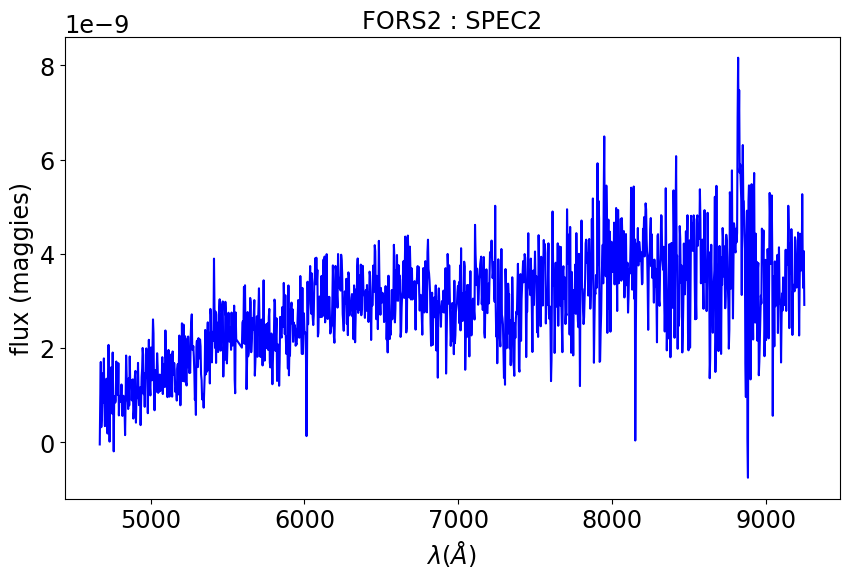

In [19]:
idx=0
fig = plt.figure(figsize=(10,6))
ax=fig.add_subplot(1,1,1)
ax.plot(all_df[idx]["wl"], all_df[idx]["fl"],'b-')
ax.set_xlabel("$\lambda  (\AA)$ ")
title = f"FORS2 : {key_tags[idx]}"
ax.set_title(title)
ax.set_ylabel("flux (maggies)")

# Plots

## Position of SL galaxies vs redshifts

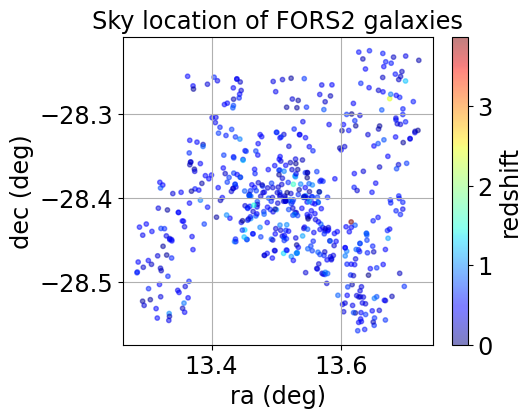

In [20]:
fig = plt.figure(figsize=(5,4))
ax = fig.add_subplot(1,1,1)
#im = ax.scatter(all_ra,all_dec,c=all_colors2,s=10,marker="o",alpha=0.5,cmap=jet2)
im = ax.scatter(df_info.ra,df_info.dec,c=df_info.redshift,s=10,marker="o",alpha=0.5,cmap="jet")
ax.grid()
ax.set_xlabel("ra (deg)")
ax.set_ylabel("dec (deg)")
ax.set_title("Sky location of FORS2 galaxies")
cbar = fig.colorbar(im, ax=ax)
cbar.set_label('redshift')

## Position vs Redshift

Text(0.5, 0.98, 'redshift')

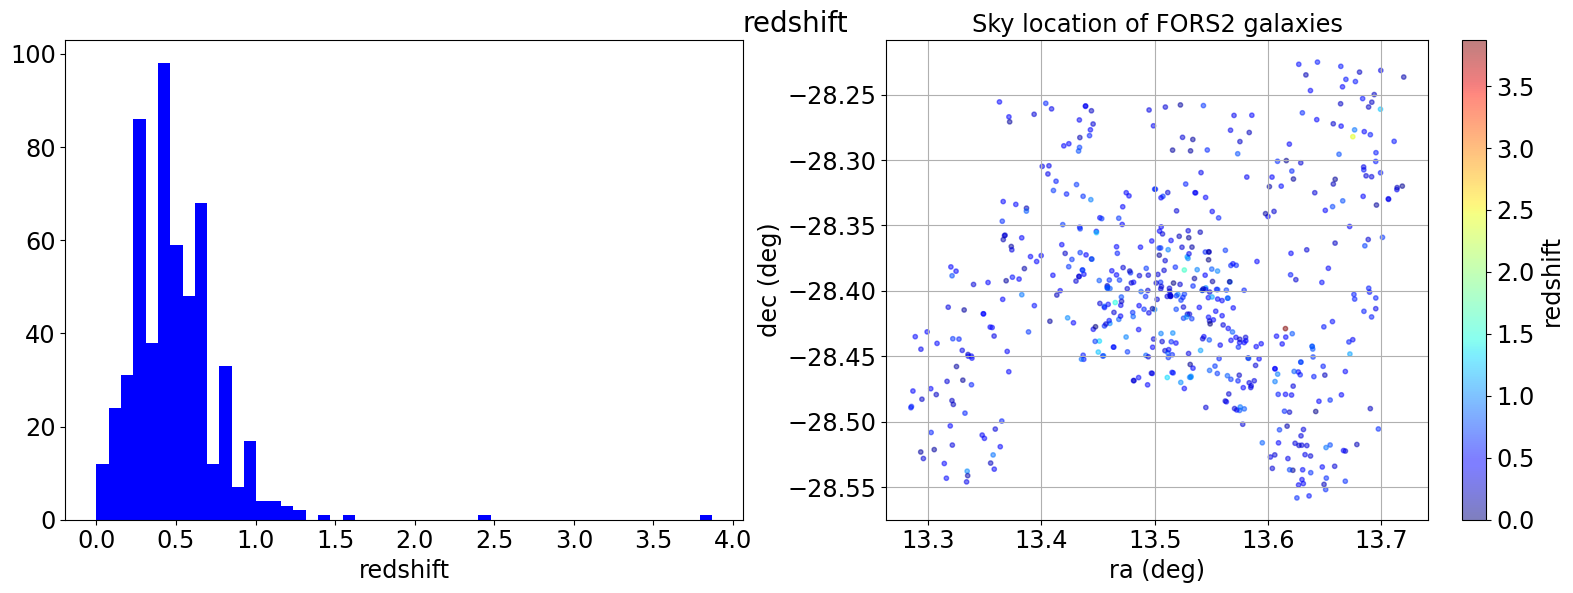

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
for idx, ax in enumerate(axes.flatten()):
    if idx == 0:
        ax.hist(df_info.redshift,bins=50,facecolor="b");
        ax.set_xlabel("redshift")
    else:
        im = ax.scatter(df_info.ra,df_info.dec,c=df_info.redshift,s=10,marker="o",alpha=0.5,cmap="jet")
        cbar = fig.colorbar(im, ax=ax)
        cbar.set_label('redshift')
        ax.grid()
        ax.set_xlabel("ra (deg)")
        ax.set_ylabel("dec (deg)")
        ax.set_title("Sky location of FORS2 galaxies")
        #fig.colorbar(im, ax=ax)
plt.tight_layout()  
plt.suptitle("redshift",fontsize=20)

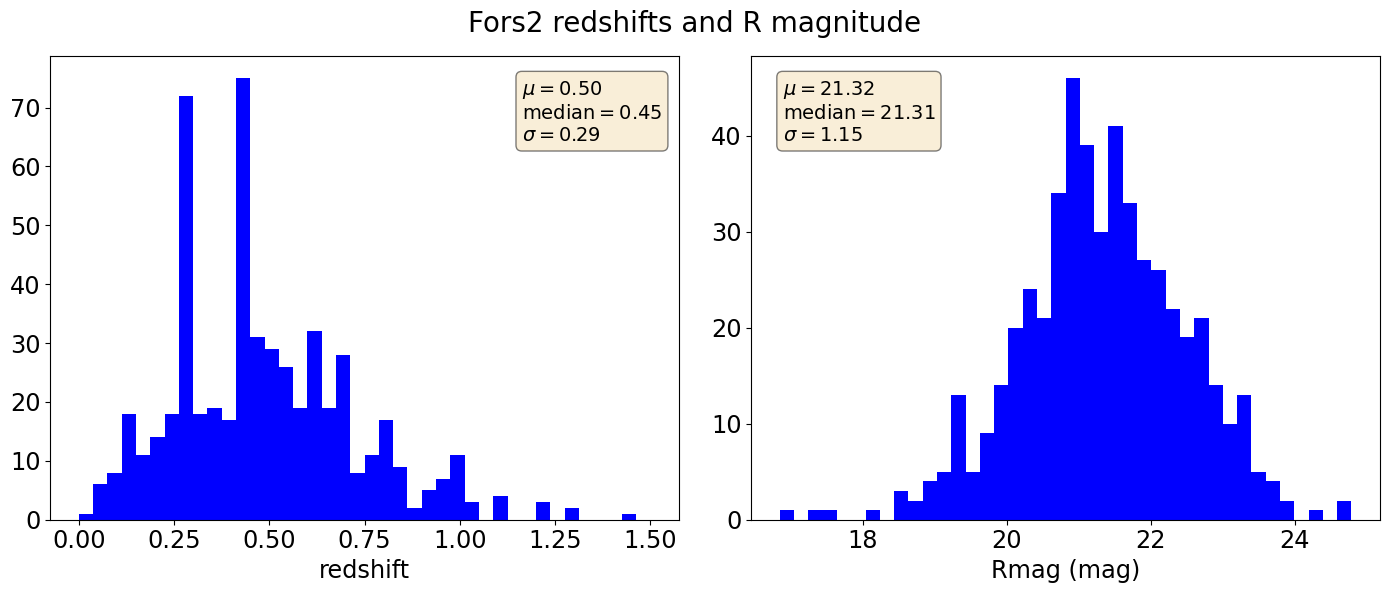

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
for idx, ax in enumerate(axes.flatten()):
    if idx == 0:
        redshifts_coll = df_info.redshift.values
        redshifts_mean = np.mean(redshifts_coll)
        redshifts_med = np.median(redshifts_coll)
        redshifts_std = np.std(redshifts_coll-redshifts_med)
        
        
        textstr = '\n'.join((
        r'$\mu=%.2f$' % (redshifts_mean, ),
        r'$\mathrm{median}=%.2f$' % (redshifts_med, ),
        r'$\sigma=%.2f$' % (redshifts_std, )))
        
        ax.hist(redshifts_coll,bins=40, range=(0,1.5),facecolor="b");
        ax.set_xlabel("redshift")
        
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

        # place a text box in upper left in axes coords
        ax.text(0.75, 0.95, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

        
    else:
        rmag_coll = df_info.Rmag.values
        rmag_index = np.where(rmag_coll>0)[0]
        rmag_coll = rmag_coll[rmag_index]
        
        rmag_mean = np.mean(rmag_coll)
        rmag_med = np.median(rmag_coll)
        rmag_std = np.std(rmag_coll-rmag_med)
        
        textstr = '\n'.join((
        r'$\mu=%.2f$' % (rmag_mean, ),
        r'$\mathrm{median}=%.2f$' % (rmag_med, ),
        r'$\sigma=%.2f$' % (rmag_std, )))
        
        ax.hist(rmag_coll,bins=40,facecolor="b");
        ax.set_xlabel("Rmag (mag)")
        
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

        # place a text box in upper left in axes coords
        ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
        
        
 
plt.suptitle("Fors2 redshifts and R magnitude",fontsize=20)
plt.tight_layout() 

In [23]:
index_selected=np.where(df_info.redshift<1)[0]

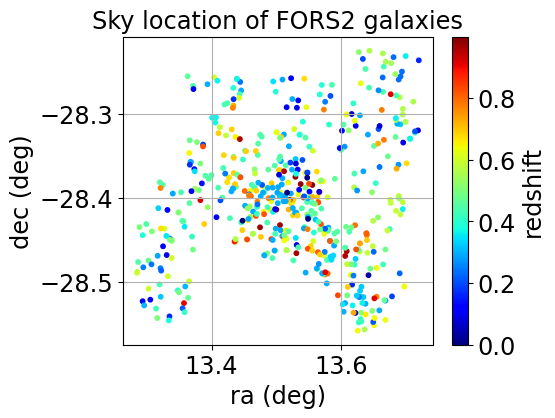

In [24]:
fig = plt.figure(figsize=(5,4))
ax = fig.add_subplot(1,1,1)
#im = ax.scatter(all_ra,all_dec,c=all_colors2,s=10,marker="o",alpha=0.5,cmap=jet2)
im = ax.scatter(df_info.ra.iloc[index_selected],df_info.dec.iloc[index_selected],c=df_info.redshift.iloc[index_selected],s=10,marker="o",alpha=1,cmap="jet")
ax.grid()
ax.set_xlabel("ra (deg)")
ax.set_ylabel("dec (deg)")
ax.set_title("Sky location of FORS2 galaxies")
cbar = fig.colorbar(im, ax=ax)
cbar.set_label('redshift')

# Plot on celestial maps
https://learn.astropy.org/tutorials/plot-catalog.html

In [25]:
gal_long = np.linspace(-180.,180,360)
gal_lat = np.zeros((360))

In [26]:
coordinates_galactic_planes = SkyCoord(l=gal_long*u.degree, b=gal_lat*u.degree, frame='galactic')
gp_radec = coordinates_galactic_planes.transform_to('icrs')  

### Fors2 spectra coordinates

In [27]:
ra_toplot = coordinates.Angle(df_info.ra.iloc[index_selected].values*u.degree)
ra_toplot = ra_toplot.wrap_at(180*u.degree)
dec_toplot = coordinates.Angle(df_info.dec.iloc[index_selected].values*u.degree)
redshifts_toplot = df_info.redshift.iloc[index_selected]

### Galactic plane coordinates

In [28]:
gp_ra_toplot = coordinates.Angle(gp_radec.ra.degree*u.degree)
gp_ra_toplot = gp_ra_toplot.wrap_at(180*u.degree)

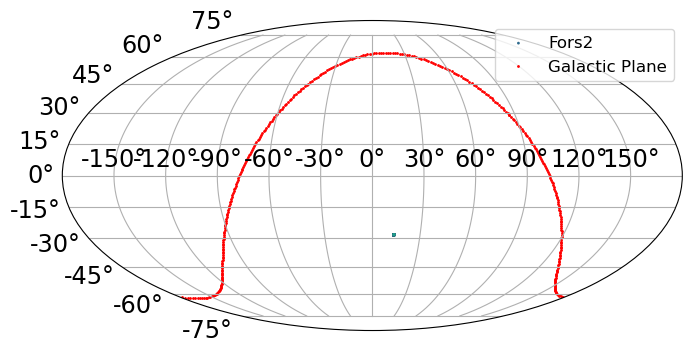

In [29]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection="mollweide")
ax.scatter(ra_toplot.radian, dec_toplot.radian,c=redshifts_toplot,label="Fors2",s=1)
ax.scatter(gp_ra_toplot.radian, gp_radec.dec.radian,c="r",label="Galactic Plane",s=1)
ax.grid()
ax.legend()

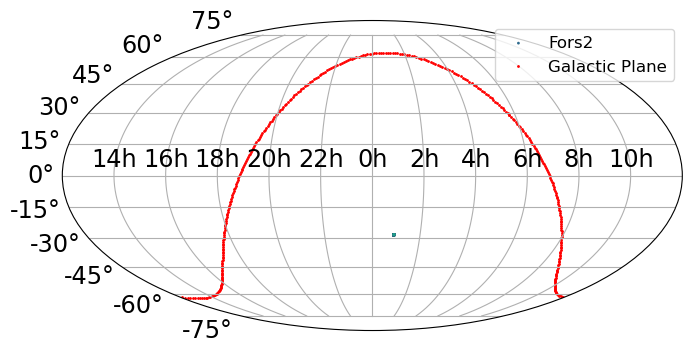

In [30]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection="mollweide")
ax.scatter(ra_toplot.radian, dec_toplot.radian,c=redshifts_toplot,label="Fors2",s=1)
ax.scatter(gp_ra_toplot.radian, gp_radec.dec.radian,c="r",label="Galactic Plane",s=1)
ax.set_xticklabels(['14h','16h','18h','20h','22h','0h','2h','4h','6h','8h','10h'])
ax.grid(True)
ax.legend()

# Position

In [31]:
df_info.describe()

num          ra         dec        Rmag    redshift          RT  \
count  550.000000  550.000000  550.000000  550.000000  550.000000  550.000000   
mean   421.587273   13.522065  -28.401811   19.889582    0.498955    9.546182   
std    199.222145    0.106640    0.074924    5.460220    0.295175    6.732525   
min      2.000000   13.284950  -28.558010    0.000000   -0.000600    0.000000   
25%    277.250000   13.450487  -28.451390   20.420000    0.294165    5.325000   
50%    433.000000   13.526855  -28.404395   21.190000    0.448555    8.450000   
75%    589.750000   13.608923  -28.355698   22.020000    0.632458   13.200000   
max    738.000000   13.719840  -28.225270   24.790000    3.869680   46.000000   

                 RV          eRV         Nsp  
count  5.500000e+02   550.000000  550.000000  
mean   1.359493e+05    91.572727    1.045455  
std    9.217559e+04   133.764362    0.262618  
min   -1.800000e+02     0.000000    1.000000  
25%    8.747250e+04    30.000000    1.000000  
50%    1.316595e+05    59.000000    1.000000  
75%    1.807305e+05   105.750000    1.000000  
max    1.160900e+06  1472.000000    4.000000

In [32]:
ra_angle = Angle(df_info.ra.mean(), u.deg)
dec_angle =  Angle(df_info.dec.mean(), u.deg)
ra_radius_std = Angle(df_info.ra.std(),u.deg)
dec_radius_std = Angle(df_info.dec.std(),u.deg)
ra_radius_minmax = Angle((df_info.ra.max()-df_info.ra.min())/2.,u.deg)
dec_radius_minmax = Angle((df_info.dec.max()-df_info.dec.min())/2.,u.deg)

In [33]:
ra_angle

<Angle 13.52206487 deg>

In [34]:
dec_angle

<Angle -28.40181098 deg>

In [35]:
ra_radius_minmax.arcmin

13.04669999999998

In [36]:
dec_radius_minmax.arcmin

9.982200000000034

## Position of galaxies vs Rmag

Text(0.5, 0.98, 'Rmag')

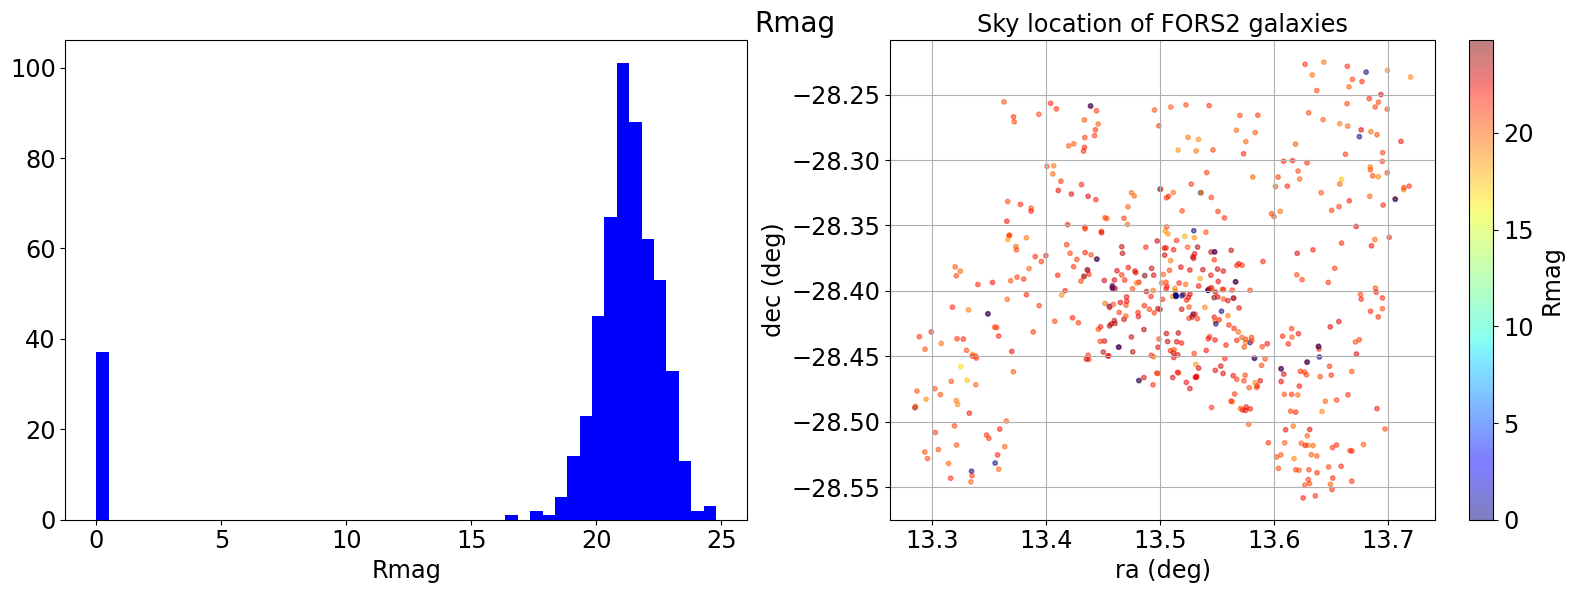

In [37]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
for idx, ax in enumerate(axes.flatten()):
    if idx == 0:
        ax.hist(df_info.Rmag,bins=50,facecolor="b");
        ax.set_xlabel("Rmag")
    else:
        im = ax.scatter(df_info.ra,df_info.dec,c=df_info.Rmag,s=10,marker="o",alpha=0.5,cmap="jet")
        cbar = fig.colorbar(im, ax=ax)
        cbar.set_label('Rmag')
        ax.grid()
        ax.set_xlabel("ra (deg)")
        ax.set_ylabel("dec (deg)")
        ax.set_title("Sky location of FORS2 galaxies")
        #fig.colorbar(im, ax=ax)
plt.tight_layout() 
plt.suptitle("Rmag",fontsize=20)

# In SkyView

https://astroquery.readthedocs.io/en/latest/skyview/skyview.html

In [38]:
SkyView.list_surveys() 

{'Allbands:GOODS/HDF/CDF': ['GOODS: Chandra ACIS HB',
                            'GOODS: Chandra ACIS FB',
                            'GOODS: Chandra ACIS SB',
                            'GOODS: VLT VIMOS U',
                            'GOODS: VLT VIMOS R',
                            'GOODS: HST ACS B',
                            'GOODS: HST ACS V',
                            'GOODS: HST ACS I',
                            'GOODS: HST ACS Z',
                            'Hawaii HDF U',
                            'Hawaii HDF B',
                            'Hawaii HDF V0201',
                            'Hawaii HDF V0401',
                            'Hawaii HDF R',
                            'Hawaii HDF I',
                            'Hawaii HDF z',
                            'Hawaii HDF HK',
                            'GOODS: HST NICMOS',
                            'GOODS: VLT ISAAC J',
                            'GOODS: VLT ISAAC H',
                            'GOODS: 

In [39]:
SkyView().get_image_list(position='RXJ0054.0-2823',survey=['DSS','GALEX Near UV','2MASS-J', '2MASS-H', '2MASS-K'])

['https://skyview.gsfc.nasa.gov/tempspace/fits/skv4066075356445_1.fits',
 'https://skyview.gsfc.nasa.gov/tempspace/fits/skv4066075356445_2.fits',
 'https://skyview.gsfc.nasa.gov/tempspace/fits/skv4066075356445_3.fits',
 'https://skyview.gsfc.nasa.gov/tempspace/fits/skv4066075356445_4.fits',
 'https://skyview.gsfc.nasa.gov/tempspace/fits/skv4066075356445_5.fits']

## DSS

In [40]:
all_img = SkyViewClass().get_images(position='RXJ0054.0-2823',survey=['DSS'],radius=0.5*u.deg)

In [41]:
the_img = all_img[0]

In [42]:
the_img[0].header

SIMPLE  =                    T / Written by SkyView Sat Dec 23 11:12:08 EST 2023
BITPIX  =                  -32 / 4 byte floating point                          
NAXIS   =                    2 / Two dimensional image                          
NAXIS1  =                  300 / Width of image                                 
NAXIS2  =                  300 / Height of image                                
CRVAL1  =              13.5117 / Reference longitude                            
CRVAL2  =             -28.3994 / Reference latitude                             
RADESYS = 'FK5     '           / Coordinate system                              
EQUINOX =               2000.0 / Epoch of the equinox                           
CTYPE1  = 'RA---TAN'           / Coordinates -- projection                      
CTYPE2  = 'DEC--TAN'           / Coordinates -- projection                      
CRPIX1  =                150.5 / X reference pixel                              
CRPIX2  =                150

In [43]:
wcs = WCS(the_img[0].header)

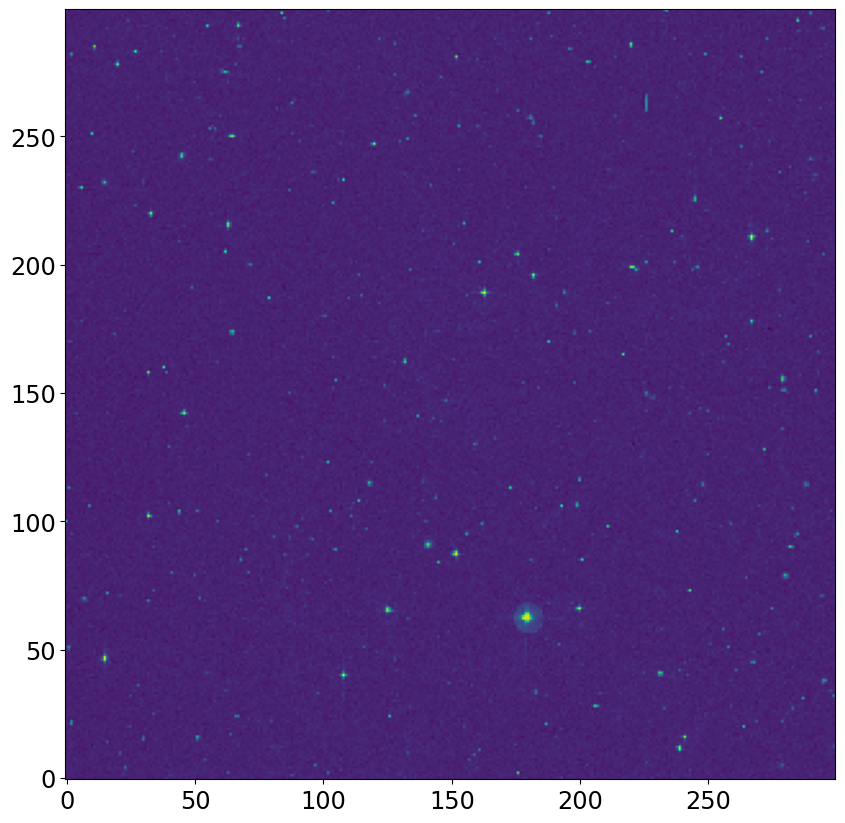

In [44]:
fig = plt.figure(figsize=(10,10))
#fig.set_figheight(15)
#fig.set_figwidth(15)
ax = fig.add_subplot(1,1,1)
ax.imshow(the_img[0].data,origin='lower')
plt.show()

In [45]:
wcs

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 13.5117 -28.3994 
CRPIX : 150.5 150.5 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.0016666666666666666 0.0016666666666666666 
NAXIS : 300  300

Text(0.5, 1.0, 'DSS')

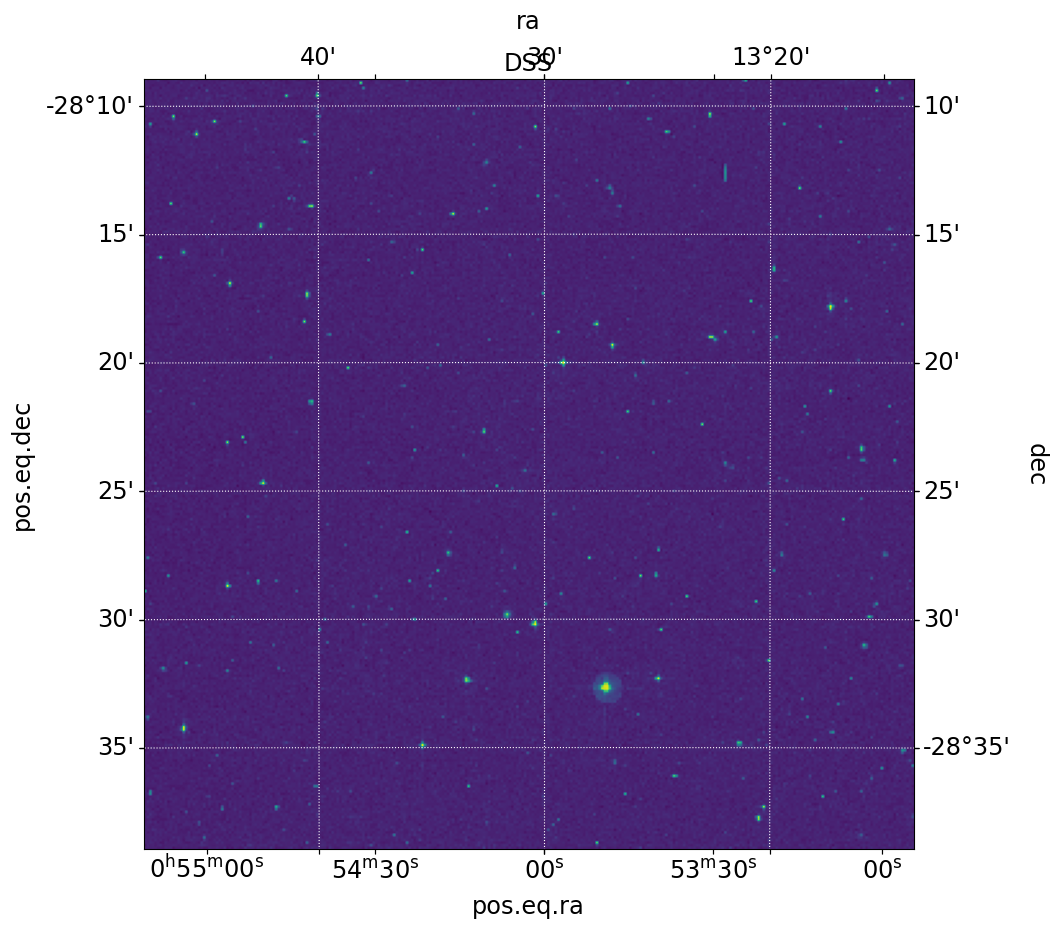

In [46]:
fig=plt.figure(figsize=(10,10))
ax = plt.subplot(projection=wcs)
ax.imshow(the_img[0].data, origin='lower')
overlay = ax.get_coords_overlay('icrs')
overlay.grid(color='white', ls='dotted')
ax.set_title("DSS")

Text(0.5, 1.0, 'FORS2 and DSS')

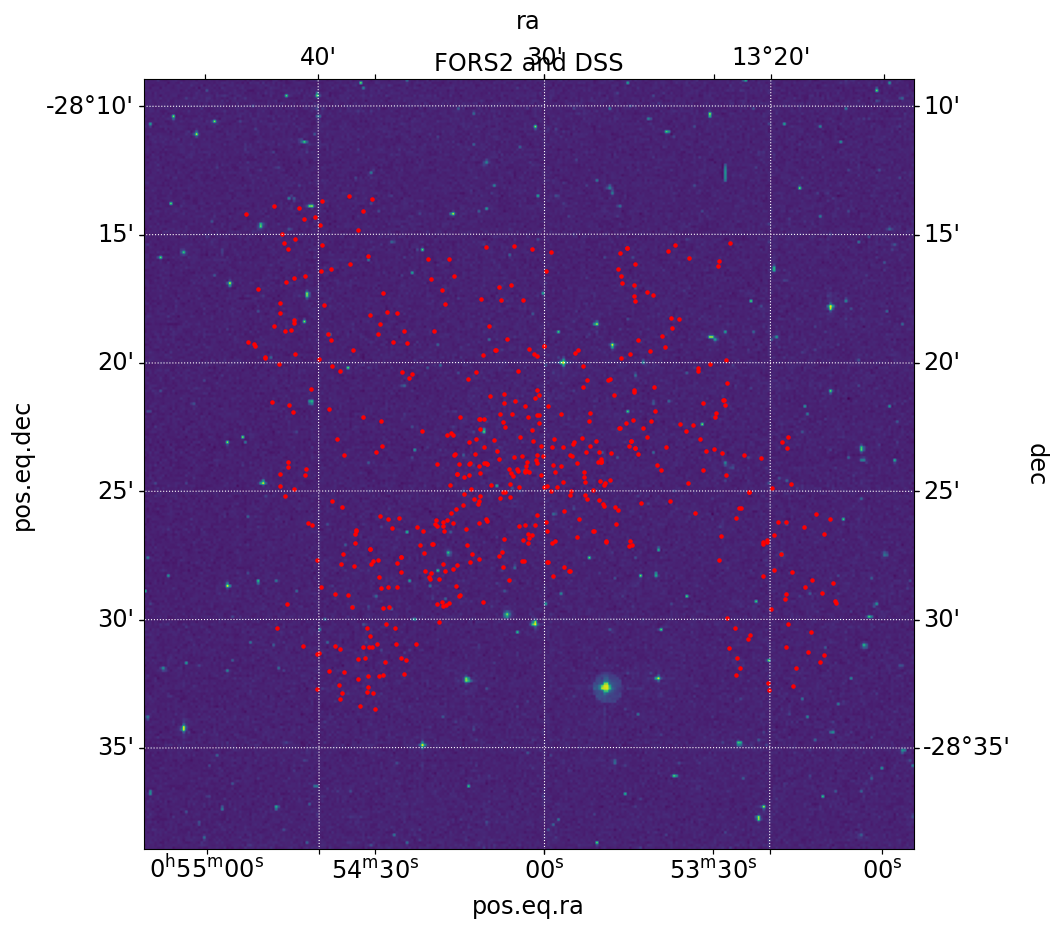

In [47]:
fig=plt.figure(figsize=(10,10))
ax = plt.subplot(projection=wcs)
ax.imshow(the_img[0].data, origin='lower')
overlay = ax.get_coords_overlay('icrs')
overlay.grid(color='white', ls='dotted')

ax.scatter(ra_toplot.deg, dec_toplot.deg, transform=ax.get_transform('icrs'),c='r',s=5)
ax.set_title("FORS2 and DSS")

## GALEX

In [48]:
all_img = SkyViewClass().get_images(position='RXJ0054.0-2823',survey=['GALEX Near UV'],radius=0.5*u.deg)
the_img = all_img[0]

In [49]:
wcs = WCS(the_img[0].header)

In [50]:
from astropy.visualization import (MinMaxInterval, SqrtStretch,ImageNormalize,ManualInterval, PercentileInterval, AsymmetricPercentileInterval,ZScaleInterval)
                        
from astropy.visualization.stretch import SinhStretch, LinearStretch,SqrtStretch,LogStretch
interval = ZScaleInterval()
transform = SqrtStretch() + ZScaleInterval()

from matplotlib.colors import LogNorm

norm = ImageNormalize(the_img[0].data, interval = MinMaxInterval(), stretch=LogStretch())


Text(0.5, 1.0, 'GALEX Near UV')

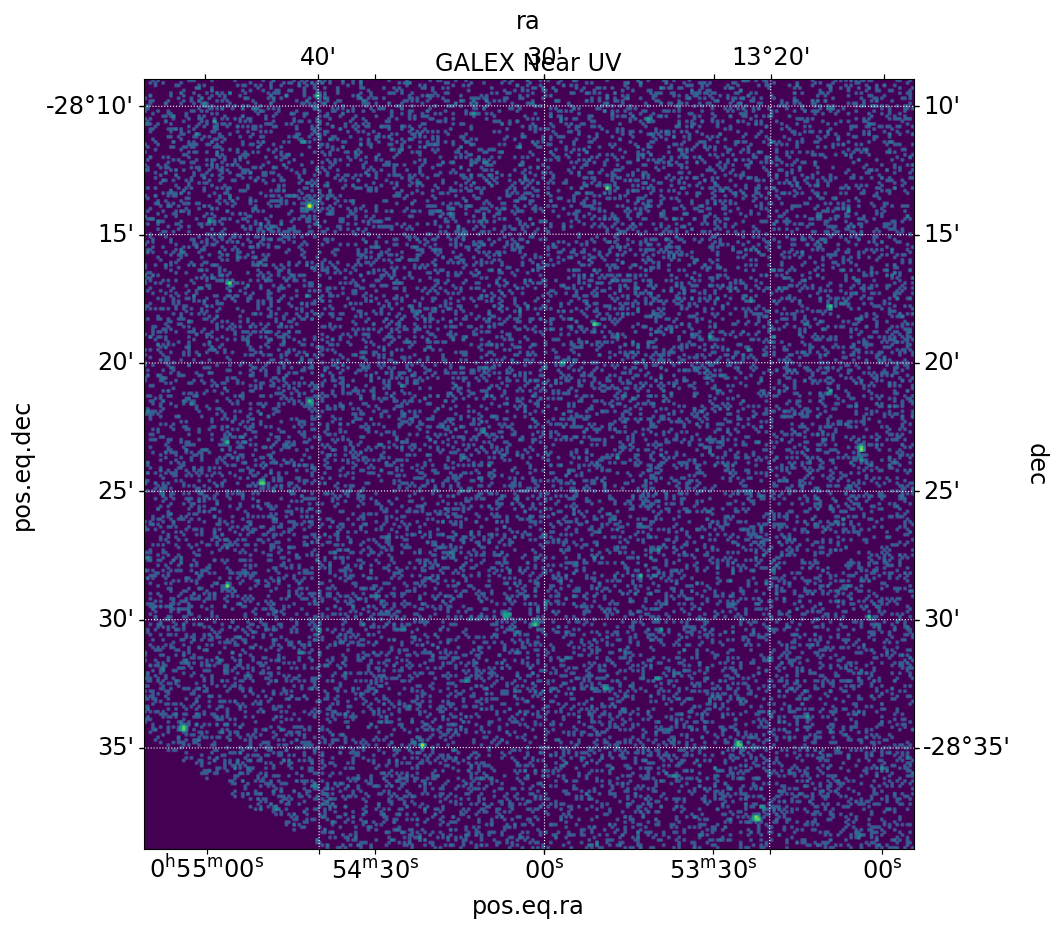

In [51]:
fig=plt.figure(figsize=(10,10))
ax = plt.subplot(projection=wcs)
ax.imshow(the_img[0].data, origin='lower',norm=norm)
overlay = ax.get_coords_overlay('icrs')
overlay.grid(color='white', ls='dotted')
ax.set_title("GALEX Near UV")

Text(0.5, 1.0, 'FORS2 and GALEX Near UV')

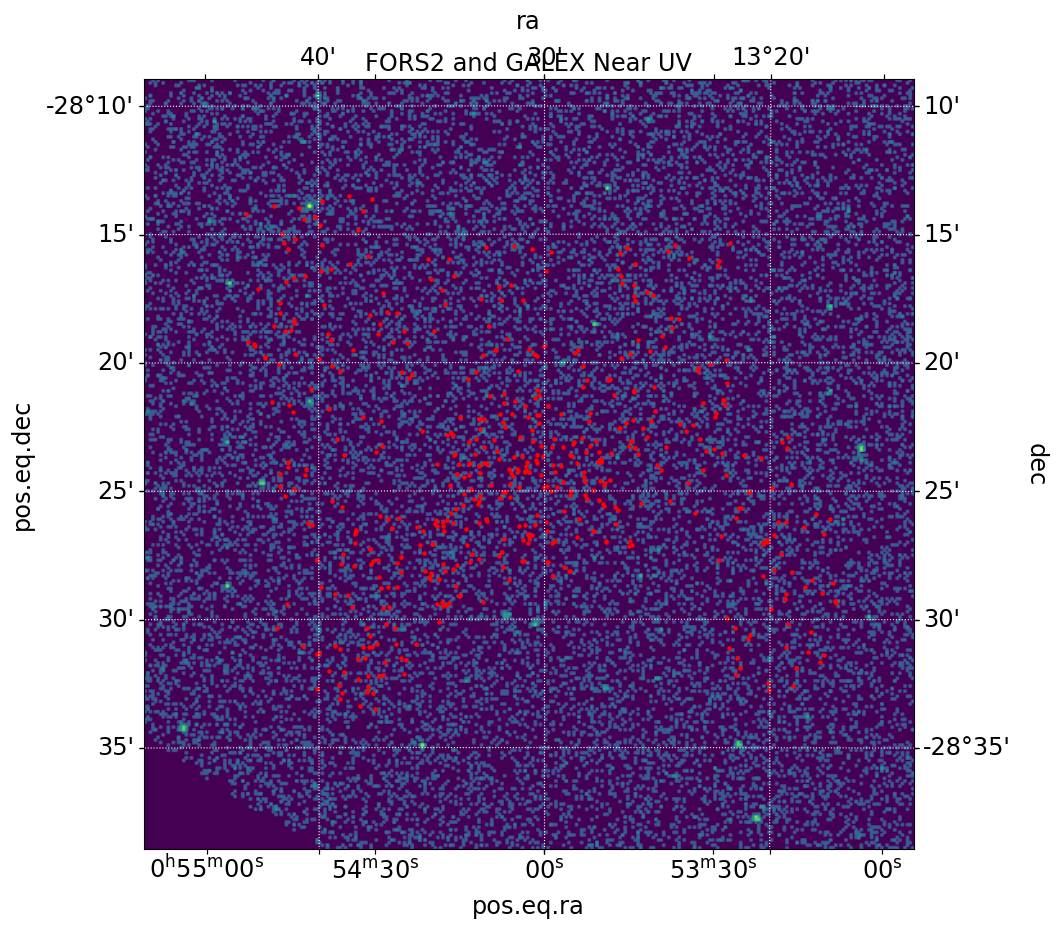

In [52]:
fig=plt.figure(figsize=(10,10))
ax = plt.subplot(projection=wcs)
ax.imshow(the_img[0].data, origin='lower',norm=norm)
overlay = ax.get_coords_overlay('icrs')
overlay.grid(color='white', ls='dotted')
ax.scatter(ra_toplot.deg, dec_toplot.deg, transform=ax.get_transform('icrs'),c='r',s=5)
ax.set_title("FORS2 and GALEX Near UV")

Text(0.5, 1.0, 'Galex FUV')

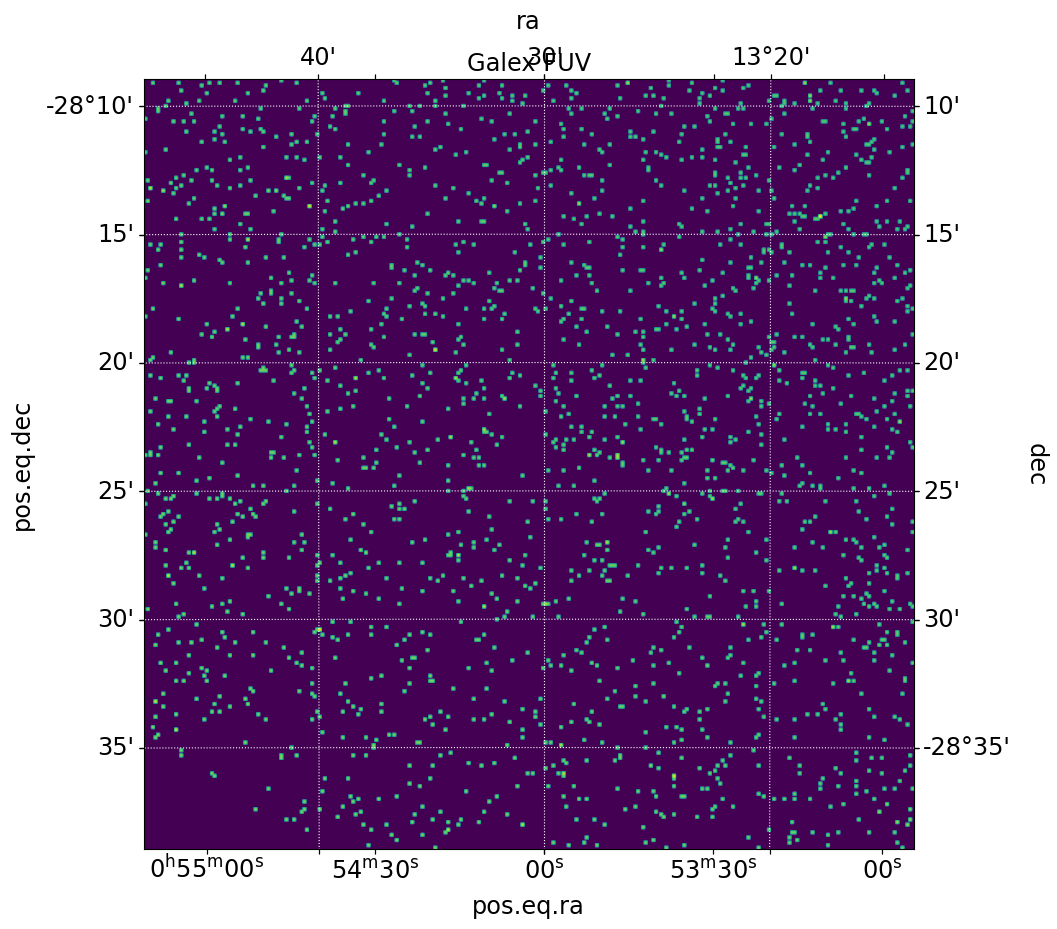

In [53]:
all_img = SkyViewClass().get_images(position='RXJ0054.0-2823',survey=['GALEX Far UV'],radius=0.5*u.deg)
the_img = all_img[0]
wcs = WCS(the_img[0].header)
norm = ImageNormalize(the_img[0].data, interval = MinMaxInterval(), stretch=LogStretch())

fig=plt.figure(figsize=(10,10))
ax = plt.subplot(projection=wcs)

ax.imshow(the_img[0].data, origin='lower',norm=norm)
overlay = ax.get_coords_overlay('icrs')
overlay.grid(color='white', ls='dotted')

ax.set_title("Galex FUV")

Text(0.5, 1.0, 'FORS2 and GALEX Far UV')

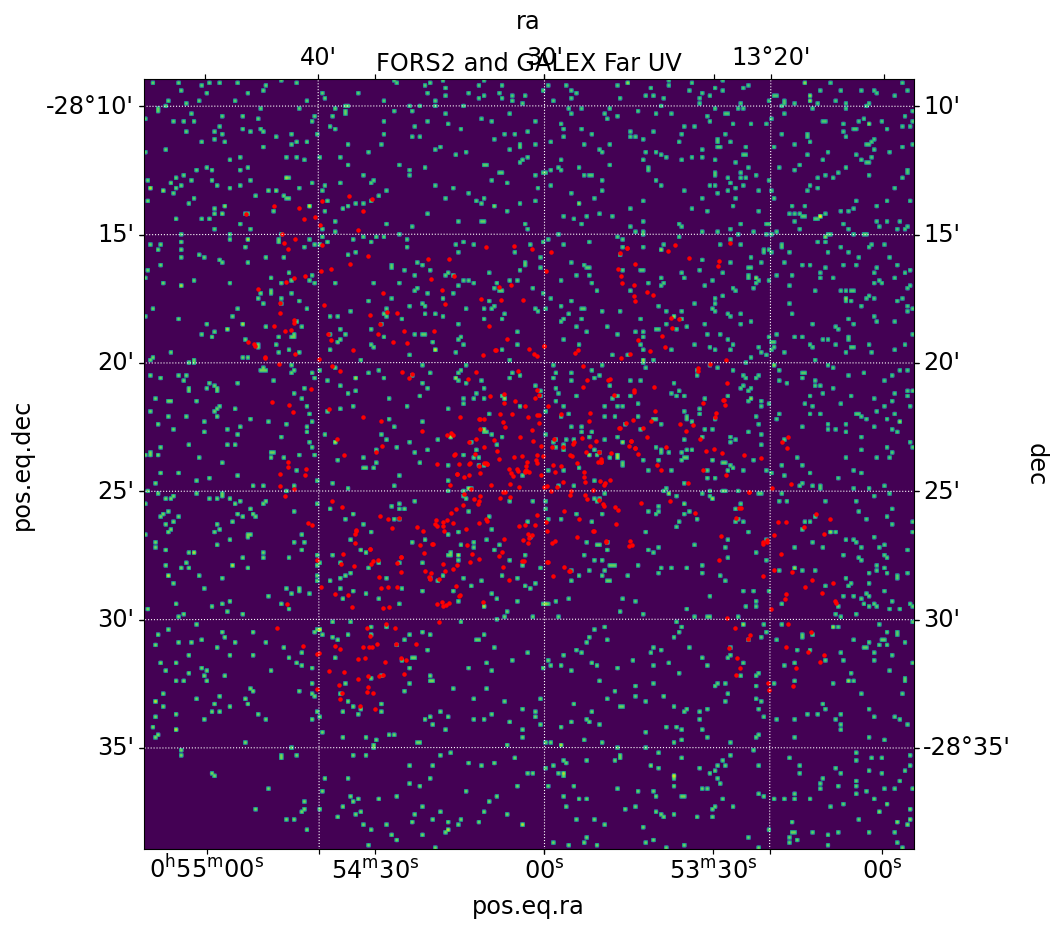

In [54]:
fig=plt.figure(figsize=(10,10))
ax = plt.subplot(projection=wcs)
ax.imshow(the_img[0].data, origin='lower',norm=norm)
overlay = ax.get_coords_overlay('icrs')
overlay.grid(color='white', ls='dotted')
ax.scatter(ra_toplot.deg, dec_toplot.deg, transform=ax.get_transform('icrs'),c='r',s=5)
ax.set_title("FORS2 and GALEX Far UV")

## 2MASS : '2MASS-J', '2MASS-H', '2MASS-K'

In [55]:
all_img = SkyViewClass().get_images(position='RXJ0054.0-2823',survey=['2MASS-J'],radius=0.5*u.deg)
the_img = all_img[0]
wcs = WCS(the_img[0].header)
norm = ImageNormalize(the_img[0].data, interval = MinMaxInterval(), stretch=LogStretch())

Text(0.5, 1.0, '2Mass-J')

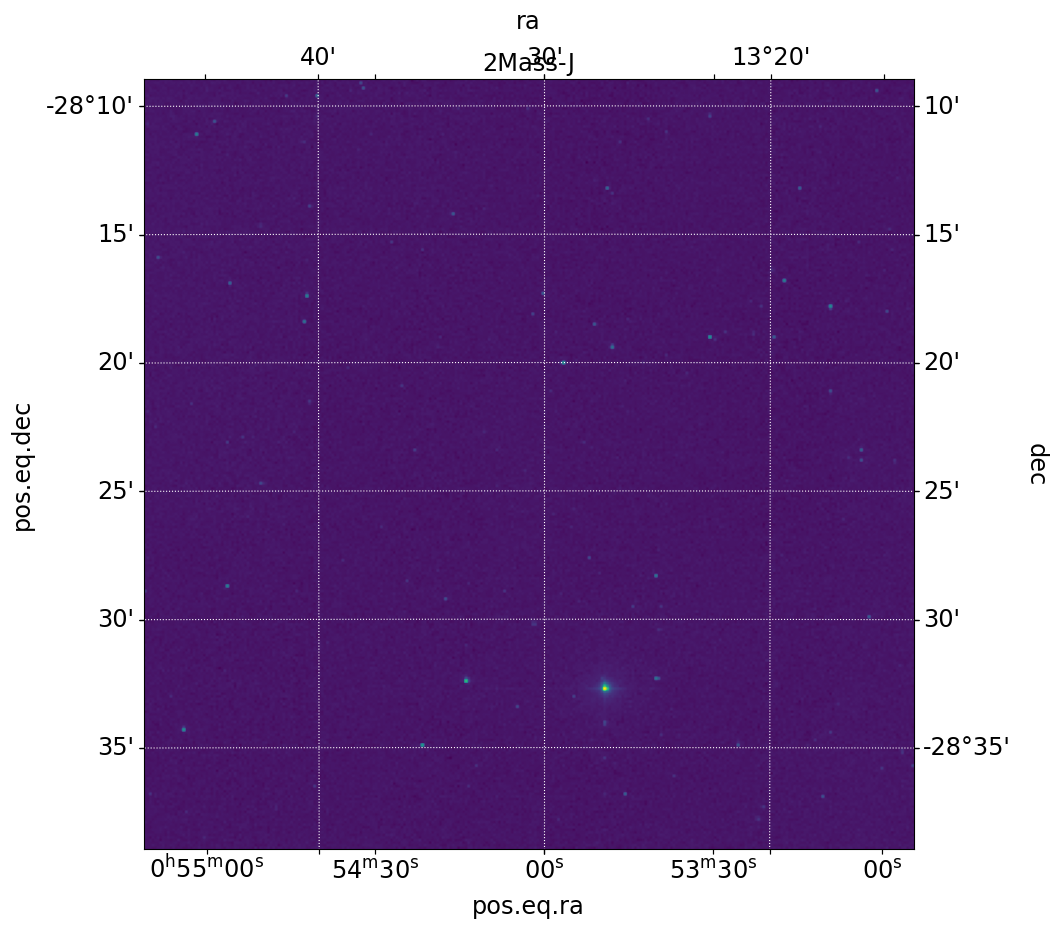

In [56]:
fig=plt.figure(figsize=(10,10))
ax = plt.subplot(projection=wcs)
ax.imshow(the_img[0].data, origin='lower',norm=norm)
overlay = ax.get_coords_overlay('icrs')
overlay.grid(color='white', ls='dotted')

#ax = fig.add_subplot(2,1,2,projection=wcs)
#ax.imshow(the_img[0].data, origin='lower',norm=norm)
#ax.scatter(ra_toplot.deg, dec_toplot.deg, transform=ax.get_transform('icrs'),c='r',s=5)
#overlay = ax.get_coords_overlay('icrs')
#overlay.grid(color='white', ls='dotted')

ax.set_title("2Mass-J")

Text(0.5, 1.0, '2Mass-H')

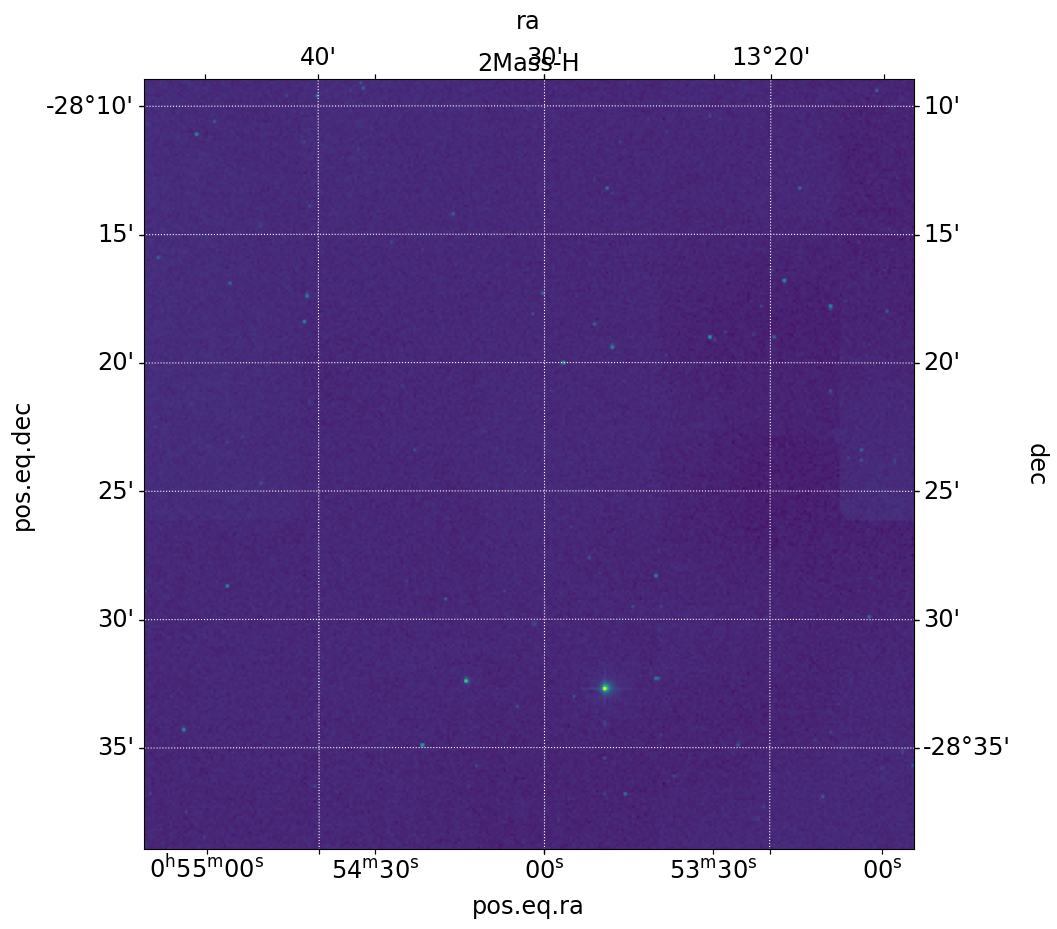

In [57]:
all_img = SkyViewClass().get_images(position='RXJ0054.0-2823',survey=['2MASS-H'],radius=0.5*u.deg)
the_img = all_img[0]
wcs = WCS(the_img[0].header)
norm = ImageNormalize(the_img[0].data, interval = MinMaxInterval(), stretch=LogStretch())

fig=plt.figure(figsize=(10,10))
ax = plt.subplot(projection=wcs)

ax.imshow(the_img[0].data, origin='lower',norm=norm)
overlay = ax.get_coords_overlay('icrs')
overlay.grid(color='white', ls='dotted')

ax.set_title("2Mass-H")

Text(0.5, 1.0, '2Mass-K')

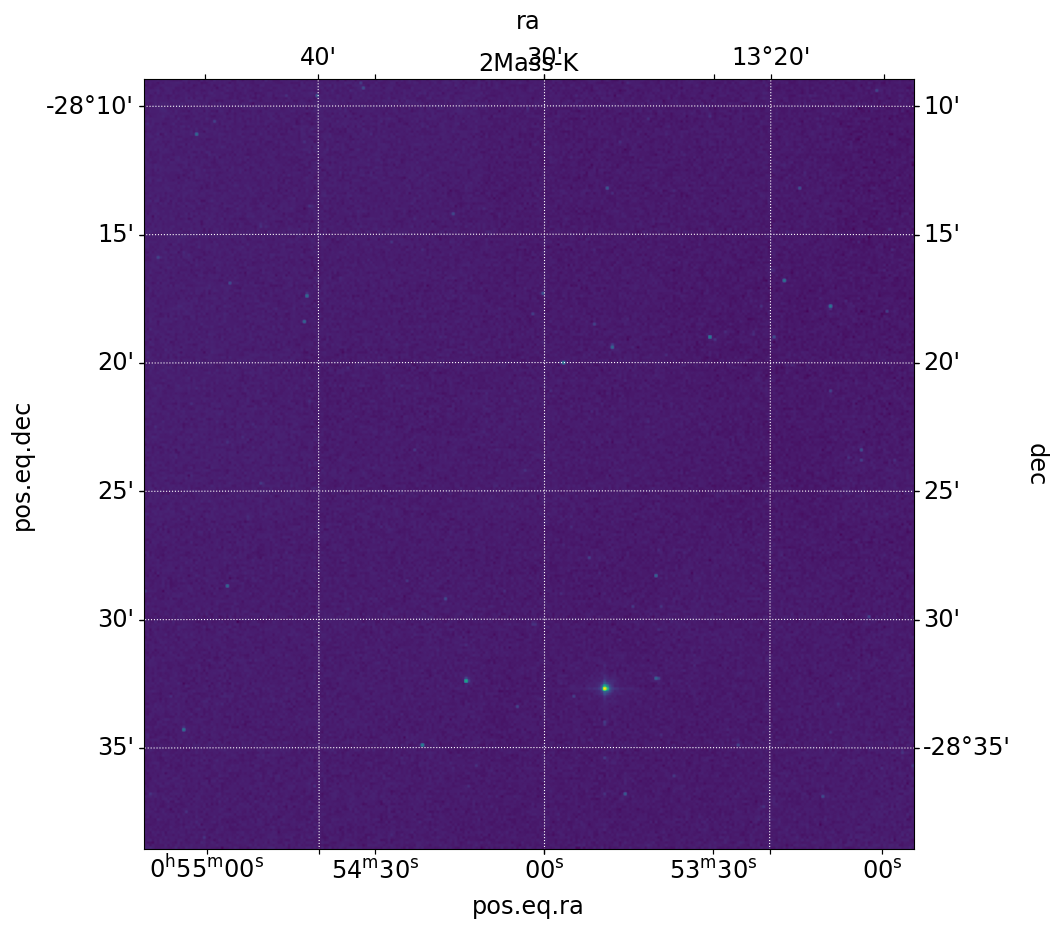

In [58]:
all_img = SkyViewClass().get_images(position='RXJ0054.0-2823',survey=['2MASS-K'],radius=0.5*u.deg)
the_img = all_img[0]
wcs = WCS(the_img[0].header)
norm = ImageNormalize(the_img[0].data, interval = MinMaxInterval(), stretch=LogStretch())

fig=plt.figure(figsize=(10,10))
ax = plt.subplot(projection=wcs)

ax.imshow(the_img[0].data, origin='lower',norm=norm)
overlay = ax.get_coords_overlay('icrs')
overlay.grid(color='white', ls='dotted')

ax.set_title("2Mass-K")

## MAST Missions

In [59]:
ra_angle

<Angle 13.52206487 deg>

In [60]:
dec_angle

<Angle -28.40181098 deg>

In [61]:
from astroquery.mast import MastMissions

missions = MastMissions()

In [62]:
missions.mission

'hst'

# SDSS

https://astroquery.readthedocs.io/en/latest/sdss/sdss.html

In [63]:
coords = coordinates.SkyCoord(df_info.ra.mean(),df_info.dec.mean(), unit="deg")  # defaults to ICRS frame

In [64]:
th1 = (df_info.ra.max()-df_info.ra.min())/2.

In [65]:
th2 = (df_info.dec.max()-df_info.dec.min())/2.

In [66]:
max_radius = Angle(max(th1,th2),u.deg)

In [67]:
max_radius

<Angle 0.217445 deg>

In [68]:
result_spectro = SDSS.query_region(coords,radius = max_radius, spectro=True )
results = SDSS.query_region(coords)

In [69]:
coordinates.SkyCoord('0h8m05.63s +14d50m23.3s')

<SkyCoord (ICRS): (ra, dec) in deg
    (2.02345833, 14.83980556)>

In [70]:
results = SDSS.query_region(coordinates.SkyCoord('0h8m05.63s +14d50m23.3s'),spectro=True)

In [71]:
results

<Table length=1>
       ra              dec               objid         run  rerun ... plate  mjd  fiberID     specobjid      run2d
    float64          float64             int64        int64 int64 ... int64 int64  int64        int64        int64
---------------- ---------------- ------------------- ----- ----- ... ----- ----- ------- ------------------ -----
2.02344596573482 14.8398237551311 1237652943176138868  1739   301 ...   751 52251     160 845594848269461504    26

In [72]:
pos = coordinates.SkyCoord('0h8m05.63s +14d50m23.3s', frame='icrs')
xid = SDSS.query_region(pos, radius='5 arcsec', spectro=True)
print(xid)

       ra              dec               objid        run  rerun ... plate  mjd  fiberID     specobjid      run2d
---------------- ---------------- ------------------- ---- ----- ... ----- ----- ------- ------------------ -----
2.02344596573482 14.8398237551311 1237652943176138868 1739   301 ...   751 52251     160 845594848269461504    26


In [73]:
redshift = xid['z'][0]
redshift

0.04559058

In [74]:
sp = SDSS.get_spectra(matches=xid)
im = SDSS.get_images(matches=xid, band='g')

`sp[0]` stores all the files related to the spectra for the object of interest. This is actually an array of several HDU in the FITS format 

The spectrum is stored as a table in the second item of the list. That means that we can get the Table doing the following

In [75]:
spectra_data = sp[0][1].data

In [76]:
spectra_data

FITS_rec([(30.596626, 3.5797, 0.06440803, 0,        0, 1.2189666 , 8.154254 , 36.077015),
          (33.245728, 3.5798, 0.        , 0,        0, 1.2187515 , 7.656426 , 34.99724 ),
          (35.89512 , 3.5799, 0.06292833, 0,        0, 1.2185355 , 7.231167 , 35.379208),
          ...,
          (53.27969 , 3.9635, 0.2728394 , 0,        0, 0.64196426, 4.1553526, 50.13611 ),
          (50.236168, 3.9636, 0.2806295 , 0,        0, 0.64184296, 4.2312737, 50.03317 ),
          (51.702717, 3.9637, 0.18243204, 0, 33554432, 0.64171964, 4.3413963, 50.208874)],
         dtype=(numpy.record, [('flux', '>f4'), ('loglam', '>f4'), ('ivar', '>f4'), ('and_mask', '>i4'), ('or_mask', '>i4'), ('wdisp', '>f4'), ('sky', '>f4'), ('model', '>f4')]))

In [77]:
spectra_data.shape

(3841,)

Text(0.5, 1.0, 'SDSS spectra')

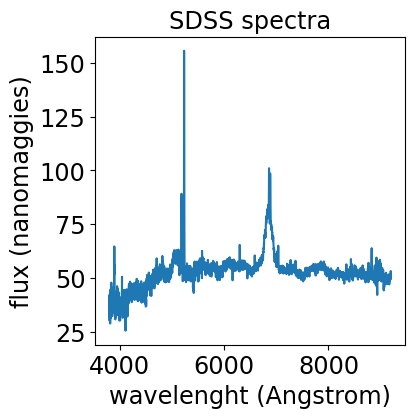

In [78]:
plt.plot(10**spectra_data['loglam'], spectra_data['flux'])
plt.xlabel('wavelenght (Angstrom)')
plt.ylabel('flux (nanomaggies)')
plt.title('SDSS spectra')

In [79]:
lines = sp[0][3].data

In [80]:
lines['LINENAME']

chararray(['Ly_alpha', 'N_V 1240', 'C_IV 1549', 'He_II 1640',
           'C_III] 1908', 'Mg_II 2799', '[O_II] 3725', '[O_II] 3727',
           '[Ne_III] 3868', 'H_epsilon', '[Ne_III] 3970', 'H_delta',
           'H_gamma', '[O_III] 4363', 'He_II 4685', 'H_beta',
           '[O_III] 4959', '[O_III] 5007', 'He_II 5411', '[O_I] 5577',
           '[O_I] 6300', '[S_III] 6312', '[O_I] 6363', '[N_II] 6548',
           'H_alpha', '[N_II] 6583', '[S_II] 6716', '[S_II] 6730',
           '[Ar_III] 7135'], dtype='<U13')

In [81]:
for n in ['[O_II] 3727', '[O_III] 5007', 'H_alpha']:
    print(n, " ->", lines['LINEWAVE'][lines['LINENAME']==n])

[O_II] 3727  -> [3729.875448]
[O_III] 5007  -> [5008.23963773]
H_alpha  -> [6564.61389433]


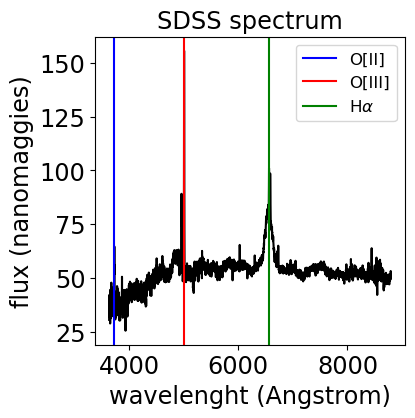

In [82]:
plt.plot(10**spectra_data['loglam']/(1+redshift), spectra_data['flux'], color='black')
plt.axvline(x=lines['LINEWAVE'][lines['LINENAME']=='[O_II] 3727'], label=r'O[II]', color='blue')
plt.axvline(x=lines['LINEWAVE'][lines['LINENAME']=='[O_III] 5007'], label=r'O[III]', color='red')
plt.axvline(x=lines['LINEWAVE'][lines['LINENAME']=='H_alpha'], label=r'H$\alpha$', color='green')

plt.xlabel('wavelenght (Angstrom)')
plt.ylabel('flux (nanomaggies)')
plt.title('SDSS spectrum')
plt.legend()

In [83]:
sp[0].info()

Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     139   ()      
  1  COADD         1 BinTableHDU     26   3841R x 8C   ['E', 'E', 'E', 'J', 'J', 'E', 'E', 'E']   
  2  SPECOBJ       1 BinTableHDU    262   1R x 126C   [6A, 4A, 16A, 23A, 16A, 8A, E, E, E, J, E, E, J, B, B, B, B, B, B, J, 22A, 19A, 19A, 22A, 19A, I, 3A, 3A, 1A, J, D, D, D, E, E, 19A, 8A, J, J, J, J, K, K, J, J, J, J, J, J, K, K, K, K, I, J, J, J, J, 5J, D, D, 6A, 21A, E, E, E, J, E, 24A, 10J, J, 10E, E, E, E, E, E, E, J, E, E, E, J, E, 5E, E, 10E, 10E, 10E, 5E, 5E, 5E, 5E, 5E, J, J, E, E, E, E, E, E, 25A, 21A, 10A, E, E, E, E, E, E, E, E, J, E, E, J, 1A, 1A, E, E, J, J, 1A, 5E, 5E]   
  3  SPZLINE       1 BinTableHDU     48   29R x 19C   ['J', 'J', 'J', '13A', 'D', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'J', 'J', 'E', 'E']   
  4  B1-00012103-00012101-00012102    1 BinTableHDU    146   2044R x 7C   [E, E, E, J, E, 

In [84]:
sp[0][2].data

FITS_rec([('sdss', 'SDSS', 'chunk24', 'legacy', 'dr2001.10.1', 'good', 18.0661, 0., 5000., -1, 0., -9999., -1, 1, 1, 0, 0, 0, 0, 0, '    845594848269461504', '1237652943176138868', '1237652943176138868', '         7470579384473', '845550867804350464', 1, 'dr7', '26', '', -1, 0.96604282, 0.03413061, 0.2561179, 113.21073, -28.737019, 'GALAXY', 'SCIENCE', 6240, 0, 6240, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 751, 515, 52251, 160, [1739,    0,    3,  315,  153], 2.0234369, 14.839836, 'QSO', 'BROADLINE', 0.04559058, 3.6422865e-05, 3.6396828, 3751, 1.5546794, 'spEigenQSO-53724.fits', [ 0,  1,  2,  3, -1, -1, -1, -1, -1, -1], 3, [ 2.1908362e-03,  3.4339433e-03, -6.1753937e-03,  8.5440716e-03, -5.8567975e+02,  1.4279556e+03, -8.0151349e+02,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00], 0., 0., 0., 0., 0., 0., 0, 3799.2686, 9198.14, 0.3758, 0, 31.981264, [10.666473, 26.243982, 39.083405, 39.87929 , 30.720493], 1.5515354, [0.51277274, 0.21740288, 0.0811602 , 0.03698776, 0.01995743, 0.01224

In [85]:
xid = SDSS.query_region(pos, radius='5 arcmin', spectro=True)

/Users/dagoret/anaconda3/envs/conda_py310/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


In [86]:
print(xid)

       ra              dec               objid        run  rerun ...  mjd  fiberID      specobjid       run2d 
---------------- ---------------- ------------------- ---- ----- ... ----- ------- ------------------- -------
1.95947794572834 14.7610869844499 1237656495114485963 2566   301 ... 52251     157  845594023635740672      26
2.02344596573482 14.8398237551311 1237652943176138868 1739   301 ... 52251     160  845594848269461504      26
2.09108576486022 14.8055580359542 1237652943176204413 1739   301 ... 52251     301  846759505961183232      26
2.03328551497378 14.7810481138112 1237652943176139448 1739   301 ... 56268     984 6954954309587935232 v5_10_0
2.02276620724587 14.8881787574371 1237652943176139008 1739   301 ... 52251     311  846762254740252672      26
2.07666156579126 14.8434552919226 1237652943176204410 1739   301 ... 56191     560 6881654266118774784 v5_10_0
2.01642429865501 14.8109891204103 1237652943176139005 1739   301 ... 52251     302  846759780839090176      26


In [87]:
sp = SDSS.get_spectra(matches=xid)

In [88]:
sp[2]

[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x166cb9cf0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x1652db790>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x1655d35e0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x1655d3fa0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x1178af640>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x165eb5300>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x165eb7af0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x165f911e0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x165f92fe0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x16629d1b0>]